# Step 1:  Imports

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import tree, metrics

from sklearn.pipeline import Pipeline, FeatureUnion
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#import warnings
#warnings.filterwarnings("ignore")

# Step 2:  Load the Data

In [2]:
df = pd.read_csv('Suicide_Detection_Cleaned.csv')

In [3]:
df.head(5)

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,text,class,clean,word,clean_text,length,sentiment,flesch_kincaid,repetition
0,0,0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently i left my ...,"['ex', 'wife', 'threatening', 'suiciderecently...",ex wife threatening suiciderecently left wife ...,345,0.100000,24.4,0
1,1,1,3,Am I weird I don't get affected by compliments...,non-suicide,am i weird i do not get affected by compliment...,"['weird', 'affected', 'compliment', 'coming', ...",weird affected compliment coming know irl feel...,69,0.100000,8.4,0
2,2,2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so i can never hear h...,"['finally', 'hear', 'bad', 'year', 'swear', 'f...",finally hear bad year swear fucking god annoying,48,-0.525000,6.4,0
3,3,3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard,"['need', 'helpjust', 'help', 'im', 'cry', 'hard']",need helpjust help im cry hard,30,-0.291667,-1.5,0
4,4,4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,i am so losthello my name is adam and i have ...,"['losthello', 'adam', 'struggling', 'year', 'a...",losthello adam struggling year afraid past yea...,1281,-0.228461,74.7,2


In [4]:
df = df.dropna()

In [5]:
df['class'][df['class'] == 'suicide'] = 1
df['class'][df['class'] == 'non-suicide'] = 0

C:\Users\betha\AppData\Local\Temp\ipykernel_10488\3149362354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'][df['class'] == 'suicide'] = 1
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\3149362354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'][df['class'] == 'non-suicide'] = 0


In [6]:
df['class'] = df['class'].astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232049 entries, 0 to 232048
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0.2    232049 non-null  int64  
 1   Unnamed: 0      232049 non-null  int64  
 2   Unnamed: 0.1    232049 non-null  int64  
 3   text            232049 non-null  object 
 4   class           232049 non-null  int32  
 5   clean           232049 non-null  object 
 6   word            232049 non-null  object 
 7   clean_text      232049 non-null  object 
 8   length          232049 non-null  int64  
 9   sentiment       232049 non-null  float64
 10  flesch_kincaid  232049 non-null  float64
 11  repetition      232049 non-null  int64  
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 20.4+ MB


It looks like we have 232,052 rows of data and no columns are null.  With that we have no data to impute. 

# Step 3: Look at correlations

In the previous step we created variables for reading level, length, repetition and sentiment.  Are they measuring the same thing?

In [8]:
df1 = df[['length', 'sentiment', 'flesch_kincaid', 'repetition', 'class']]
df1.head()

,length,sentiment,flesch_kincaid,repetition,class
0,345,0.100000,24.4,0,1
1,69,0.100000,8.4,0,0
2,48,-0.525000,6.4,0,0
3,30,-0.291667,-1.5,0,1
4,1281,-0.228461,74.7,2,1


In [9]:
df1.corr()

,length,sentiment,flesch_kincaid,repetition,class
length,1.000000,-0.002195,0.885668,0.090969,0.093813
sentiment,-0.002195,1.000000,-0.000907,-0.000690,-0.098727
flesch_kincaid,0.885668,-0.000907,1.000000,0.022114,0.008996
repetition,0.090969,-0.000690,0.022114,1.000000,-0.013508
class,0.093813,-0.098727,0.008996,-0.013508,1.000000



We can see that reading level and length of post are highly correlated.  However since the correlation is less than 0.95, I think we can keep both variables.


# Naive Bayes with Count Vectorizer - Text Only

In [10]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'])
X = X.tocsc() 
y = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [11]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=12)

In [12]:
n_est = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]
#n_est = [int(n) for n in np.logspace(start=0, stop=3, num=30)]
param_grid = {'alpha':n_est}
nbcv = MultinomialNB()
nbcv_cv= GridSearchCV(nbcv,param_grid,cv=5)
nbcv_cv.fit(X_train1, y_train1)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [13]:
print("Best Score:" + str(nbcv_cv.best_score_))
print("Best Parameters: " + str(nbcv_cv.best_params_))

Best Score:0.9178273499842916
Best Parameters: {'alpha': 0.4}


In [14]:
nbcv = MultinomialNB(alpha = 0.4)
nbcv.fit(X_train1, y_train1)

MultinomialNB(alpha=0.4)

In [15]:
y_train_pred1 = nbcv.predict(X_train1)
y_pred1 = nbcv.predict(X_test1)

In [16]:
training_accuracy_nbcv = nbcv.score(X_train1, y_train1)
test_accuracy_nbcv = nbcv.score(X_test1, y_test1)

In [17]:
print("Accuracy on training data: {:2f}".format(training_accuracy_nbcv))
print("Accuracy on test data:     {:2f}".format(test_accuracy_nbcv))

Accuracy on training data: 0.949200
Accuracy on test data:     0.919139


In [18]:
from sklearn import tree, metrics
accuracy_nbcv = metrics.accuracy_score(y_test1,y_pred1)
balanced_accuracy_nbcv = metrics.balanced_accuracy_score(y_test1,y_pred1)
precision_nbcv = metrics.precision_score(y_test1,y_pred1, pos_label = 1)
recall_nbcv = metrics.recall_score(y_test1,y_pred1, pos_label = 1)
f1_nbcv = metrics.f1_score(y_test1, y_pred1, pos_label = 1)
roc_auc_nbcv = metrics.roc_auc_score(y_test1, y_pred1)
print("Accuracy:", accuracy_nbcv)
print("Balanced accuracy:", balanced_accuracy_nbcv)
print('Precision score' , precision_nbcv)
print('Recall score' , recall_nbcv)
print('F1 score' , f1_nbcv)
print('ROC_AUC Score' , roc_auc_nbcv)

Accuracy: 0.9191388137141675
Balanced accuracy: 0.9191885918301574
Precision score 0.8903647005853219
Recall score 0.9557427417406014
F1 score 0.9218960723264681
ROC_AUC Score 0.9191885918301573


In [19]:
from sklearn.metrics import confusion_matrix
tn_nbcv, fp_nbcv, fn_nbcv, tp_nbcv = confusion_matrix(y_test1, y_pred1).ravel()
print(f'True Suicide: {tp_nbcv}')
print(f'False Suicide: {fp_nbcv}')
print(f'True Non-Suicide: {tn_nbcv}')
print(f'False Non-Suicide: {fn_nbcv}')

True Suicide: 27685
False Suicide: 3409
True Non-Suicide: 25637
False Non-Suicide: 1282


In [20]:
pd.DataFrame(confusion_matrix(y_test1, y_pred1), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25637,3409
Actual Suicide,1282,27685


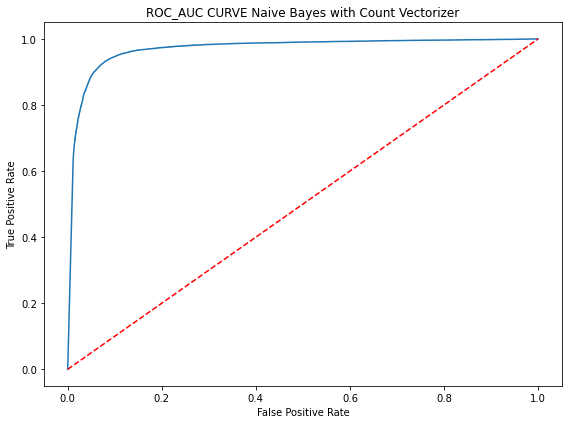

In [21]:
y_pred_proba1 = nbcv.predict_proba(X_test1)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test1,  y_pred_proba1)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr1,tpr1)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with Count Vectorizer")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Naive Bayes with Count Vectorizer.png')

# Naive Bayes with Count Vectorizer - All Features

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = MinMaxScaler()
scaler.fit(df1)
df_scaled = scaler.transform(df1)
scaled_features_df = pd.DataFrame(df_scaled, index=df1.index, columns=df1.columns)

In [23]:
scaled_features_df.head()

,length,sentiment,flesch_kincaid,repetition,class
0,0.000574,0.550000,0.000138,0.000000,1.0
1,0.000113,0.550000,0.000083,0.000000,0.0
2,0.000078,0.237500,0.000076,0.000000,0.0
3,0.000048,0.354167,0.000049,0.000000,1.0
4,0.002135,0.385769,0.000310,0.000257,1.0


In [24]:
scaled_features_df['length'].min()

0.0

In [25]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2403083902.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2403083902.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [26]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=12)

In [27]:
alphas = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]

param_grid = {'alpha':alphas}
nbcv = MultinomialNB()
nbcv_cv= GridSearchCV(nbcv,param_grid,cv=5)
nbcv_cv.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [28]:
print("Best Score:" + str(nbcv_cv.best_score_))
print("Best Parameters: " + str(nbcv_cv.best_params_))

Best Score:0.9209416495625214
Best Parameters: {'alpha': 0.5}


In [29]:
nbcvi = MultinomialNB(alpha = 0.5)
nbcvi.fit(X_train2, y_train2)

MultinomialNB(alpha=0.5)

In [30]:
y_train_pred2 = nbcvi.predict(X_train2)
y_pred2 = nbcvi.predict(X_test2)

In [31]:
training_accuracy_nbcv = nbcvi.score(X_train2, y_train2)
test_accuracy_nbcv = nbcvi.score(X_test2, y_test2)

In [32]:
print("Accuracy on training data: {:2f}".format(training_accuracy_nbcv))
print("Accuracy on test data:     {:2f}".format(test_accuracy_nbcv))

Accuracy on training data: 0.949413
Accuracy on test data:     0.922604


In [33]:
accuracy_nbcvi = metrics.accuracy_score(y_test2,y_pred2)
balanced_accuracy_nbcvi = metrics.balanced_accuracy_score(y_test2,y_pred2)
precision_nbcvi = metrics.precision_score(y_test2,y_pred2, pos_label = 1)
recall_nbcvi = metrics.recall_score(y_test2,y_pred2, pos_label = 1)
f1_nbcvi = metrics.f1_score(y_test2, y_pred2, pos_label = 1)
roc_auc_nbcvi = metrics.roc_auc_score(y_test2, y_pred2)
print("Accuracy:", accuracy_nbcvi)
print("Balanced accuracy:", balanced_accuracy_nbcvi)
print('Precision score' , precision_nbcvi)
print('Recall score' , recall_nbcvi)
print('F1 score' , f1_nbcvi)
print('ROC_AUC Score' , roc_auc_nbcvi)

Accuracy: 0.9226035543757434
Balanced accuracy: 0.922636977909941
Precision score 0.9026219692732835
Recall score 0.9471812752442434
F1 score 0.9243649349774273
ROC_AUC Score 0.922636977909941


In [34]:
from sklearn.metrics import confusion_matrix
tn_nbcvi, fp_nbcvi, fn_nbcvi, tp_nbcvi = confusion_matrix(y_test2, y_pred2).ravel()
print(f'True Suicide: {tp_nbcvi}')
print(f'False Suicide: {fp_nbcvi}')
print(f'True Non-Suicide: {tn_nbcvi}')
print(f'False Non-Suicide: {fn_nbcvi}')

True Suicide: 27437
False Suicide: 2960
True Non-Suicide: 26086
False Non-Suicide: 1530


In [35]:
pd.DataFrame(confusion_matrix(y_test2, y_pred2), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26086,2960
Actual Suicide,1530,27437


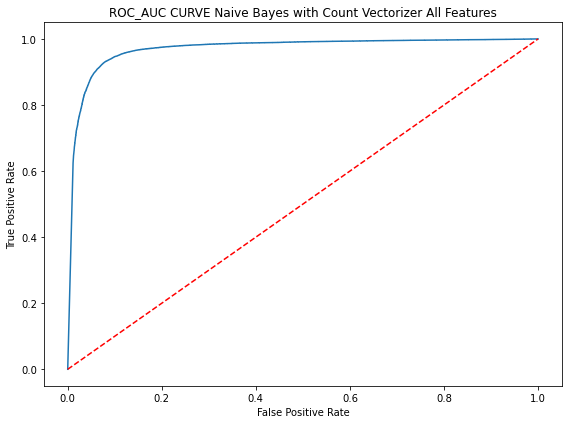

In [36]:
y_pred_proba2 = nbcvi.predict_proba(X_test2)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test2,  y_pred_proba2)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr2,tpr2)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with Count Vectorizer All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Naive Bayes with Count Vectorizer All features.png')

# Nave Bayes with TF-IDF - Text Only

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X_tfid1 = vectorizor_tfid.fit_transform(df['text'])
X_tfid1 = X_tfid1.tocsc() 
y_tfid1 = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [38]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_tfid1, y_tfid1, test_size=0.25, random_state=12)

In [39]:
n_est = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]
#n_est = [int(n) for n in np.logspace(start=0, stop=3, num=30)]
param_grid = {'alpha':n_est}
nb_tfidf = MultinomialNB()
nb_tfidf_cv= GridSearchCV(nb_tfidf,param_grid,cv=5)
nb_tfidf_cv.fit(X_train3, y_train3)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [40]:
print("Best Score:" + str(nb_tfidf_cv.best_score_))
print("Best Parameters: " + str(nb_tfidf_cv.best_params_))

Best Score:0.9194649498003097
Best Parameters: {'alpha': 0.1}


In [41]:

nb_tfidf = MultinomialNB(alpha = 0.1)
nb_tfidf.fit(X_train3, y_train3)

MultinomialNB(alpha=0.1)

In [42]:
y_train_pred3 = nb_tfidf.predict(X_train3)
y_pred3 = nb_tfidf.predict(X_test3)

In [43]:
training_accuracy_nb_tfid = nb_tfidf.score(X_train3, y_train3)
test_accuracy_nb_tfid = nb_tfidf.score(X_test3, y_test3)

In [44]:
print("Accuracy on training data: {:2f}".format(training_accuracy_nb_tfid))
print("Accuracy on test data:     {:2f}".format(test_accuracy_nb_tfid))

Accuracy on training data: 0.963686
Accuracy on test data:     0.920673


In [45]:
from sklearn import tree, metrics
accuracy_nb_tfidf = metrics.accuracy_score(y_test3,y_pred3)
balanced_accuracy_nb_tfidf = metrics.balanced_accuracy_score(y_test3,y_pred3)
precision_nb_tfidf = metrics.precision_score(y_test3,y_pred3, pos_label = 1)
recall_nb_tfidf = metrics.recall_score(y_test3,y_pred3, pos_label = 1)
f1_nb_tfidf = metrics.f1_score(y_test3, y_pred3, pos_label = 1)
roc_auc_nb_tfidf = metrics.roc_auc_score(y_test3, y_pred3)
print("Accuracy:", accuracy_nb_tfidf)
print("Balanced accuracy:", balanced_accuracy_nb_tfidf)
print('Precision score' , precision_nb_tfidf)
print('Recall score' , recall_nb_tfidf)
print('F1 score' , f1_nb_tfidf)
print('ROC_AUC Score' , roc_auc_nb_tfidf)



Accuracy: 0.9206729526140692
Balanced accuracy: 0.9207290948846546
Precision score 0.8884106488123705
Recall score 0.9619567093589256
F1 score 0.9237220712059936
ROC_AUC Score 0.9207290948846546


In [46]:
from sklearn.metrics import confusion_matrix
tn_nb_tfidf, fp_nb_tfidf, fn_nb_tfidf, tp_nb_tfidf = confusion_matrix(y_test3, y_pred3).ravel()
print(f'True Suicide: {tp_nb_tfidf}')
print(f'False Suicide: {fp_nb_tfidf}')
print(f'True Non-Suicide: {tn_nb_tfidf}')
print(f'False Non-Suicide: {fn_nb_tfidf}')

True Suicide: 27865
False Suicide: 3500
True Non-Suicide: 25546
False Non-Suicide: 1102


In [47]:
pd.DataFrame(confusion_matrix(y_test3, y_pred3), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25546,3500
Actual Suicide,1102,27865


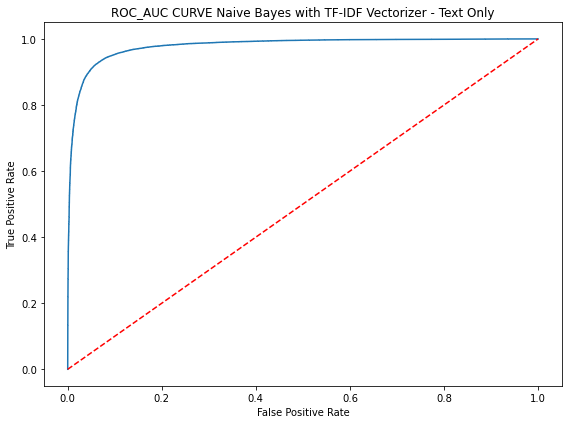

In [48]:
y_pred_proba3 = nb_tfidf.predict_proba(X_test3)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test3,  y_pred_proba3)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr3,tpr3)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with TF-IDF Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Naive Bayes with TF-IDF Vectoizer_Text_Only.png')

# Naive Bayes - TF-IDF - All Features

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix1 = vectorizor_tfid.fit_transform(df['text'])
text_matrix1 = text_matrix1.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix1, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_tfid11 = hstack((third, sentiment))

y_tfid11 = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\1915412182.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\1915412182.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [50]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_tfid11, y_tfid11, test_size=0.25, random_state=12)

In [51]:
n_est = [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2, 5, 8]
#n_est = [int(n) for n in np.logspace(start=0, stop=3, num=30)]
param_grid = {'alpha':n_est}
nb_tfidf = MultinomialNB()
nb_tfidf_cv= GridSearchCV(nb_tfidf,param_grid,cv=5)
nb_tfidf_cv.fit(X_train4, y_train4)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.75, 1, 2,
                                   5, 8]})

In [52]:
print("Best Score:" + str(nb_tfidf_cv.best_score_))
print("Best Parameters: " + str(nb_tfidf_cv.best_params_))

Best Score:0.9235043414070075
Best Parameters: {'alpha': 0.2}


In [53]:
nb_tfidf = MultinomialNB(alpha = 0.2)
nb_tfidf.fit(X_train4, y_train4)

MultinomialNB(alpha=0.2)

In [54]:
y_train_pred4 = nb_tfidf.predict(X_train4)
y_pred4 = nb_tfidf.predict(X_test4)

In [55]:
training_accuracy_nb_tfid = nb_tfidf.score(X_train4, y_train4)
test_accuracy_nb_tfid = nb_tfidf.score(X_test4, y_test4)

In [56]:
print("Accuracy on training data: {:2f}".format(training_accuracy_nb_tfid))
print("Accuracy on test data:     {:2f}".format(test_accuracy_nb_tfid))

Accuracy on training data: 0.959393
Accuracy on test data:     0.924638


In [57]:
accuracy_nb_tfidfi = metrics.accuracy_score(y_test4,y_pred4)
balanced_accuracy_nb_tfidfi = metrics.balanced_accuracy_score(y_test4,y_pred4)
precision_nb_tfidfi = metrics.precision_score(y_test4,y_pred4, pos_label = 1)
recall_nb_tfidfi = metrics.recall_score(y_test4,y_pred4, pos_label = 1)
f1_nb_tfidfi = metrics.f1_score(y_test4, y_pred4, pos_label = 1)
roc_auc_nb_tfidfi = metrics.roc_auc_score(y_test4, y_pred4)
print("Accuracy:", accuracy_nb_tfidfi)
print("Balanced accuracy:", balanced_accuracy_nb_tfidfi)
print('Precision score' , precision_nb_tfidfi)
print('Recall score' , recall_nb_tfidfi)
print('F1 score' , f1_nb_tfidfi)
print('ROC_AUC Score' , roc_auc_nb_tfidfi)

Accuracy: 0.9246375812317928
Balanced accuracy: 0.9246807265534271
Precision score 0.8991269351854857
Recall score 0.9563641385024338
F1 score 0.9268627254173777
ROC_AUC Score 0.9246807265534271


In [58]:
from sklearn.metrics import confusion_matrix
tn_nb_tfidfi, fp_nb_tfidfi, fn_nb_tfidfi, tp_nb_tfidfi = confusion_matrix(y_test4, y_pred4).ravel()
print(f'True Suicide: {tp_nb_tfidfi}')
print(f'False Suicide: {fp_nb_tfidfi}')
print(f'True Non-Suicide: {tn_nb_tfidfi}')
print(f'False Non-Suicide: {fn_nb_tfidfi}')

True Suicide: 27703
False Suicide: 3108
True Non-Suicide: 25938
False Non-Suicide: 1264


In [59]:
pd.DataFrame(confusion_matrix(y_test4, y_pred4), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25938,3108
Actual Suicide,1264,27703


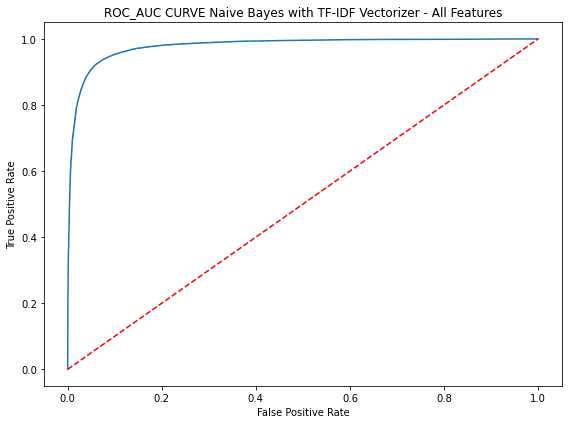

In [60]:
y_pred_proba4 = nb_tfidf.predict_proba(X_test4)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test4,  y_pred_proba4)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr4,tpr4)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with TF-IDF Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Naive Bayes with TF-IDF Vectorizer_All_Features.png')

# Random Forest - Count Vectorizor

In [61]:
from sklearn.ensemble import RandomForestClassifier


In [62]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'].head(1000))
X = X.tocsc() 
y = df['class'].head(1000)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [63]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.25, random_state=12)

In [64]:
n_est = [int(n) for n in np.logspace(start=1.5, stop=3.4, num=5)]
n_est

[31, 94, 281, 841, 2511]

In [65]:

n_est = [int(n) for n in np.logspace(start=1.5, stop=3.4, num=5)]
depth = [int(x) for x in np.linspace(10, 100, num = 6)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train5, y_train5)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [10, 28, 46, 64, 82, 100],
                         'n_estimators': [31, 94, 281, 841, 2511]})

In [66]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.8480000000000001
Best Parameters: {'max_depth': 28, 'n_estimators': 841}


In [67]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'])
X = X.tocsc() 
y = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [68]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.25, random_state=12)

In [69]:
rfcv = RandomForestClassifier(n_estimators = 28 , max_depth = 841)
rfcv.fit(X_train5, y_train5)

RandomForestClassifier(max_depth=841, n_estimators=28)

In [70]:
y_train_pred_rfcv = rfcv.predict(X_train5)
y_pred5 = rfcv.predict(X_test5)

In [71]:
training_accuracy_rfcv = rfcv.score(X_train5, y_train5)
test_accuracy_rfcv = rfcv.score(X_test5, y_pred5)

In [72]:
print("Accuracy on training data: {:2f}".format(training_accuracy_rfcv))
print("Accuracy on test data:     {:2f}".format(test_accuracy_rfcv))

Accuracy on training data: 0.994375
Accuracy on test data:     1.000000


In [73]:
from sklearn import tree, metrics
accuracy_rfcv = metrics.accuracy_score(y_test5,y_pred5)
balanced_accuracy_rfcv = metrics.balanced_accuracy_score(y_test5,y_pred5)
precision_rfcv = metrics.precision_score(y_test5,y_pred5, pos_label = 1)
recall_rfcv = metrics.recall_score(y_test5,y_pred5, pos_label = 1)
f1_rfcv = metrics.f1_score(y_test5, y_pred5, pos_label = 1)
roc_auc_rfcv = metrics.roc_auc_score(y_test5, y_pred5)
print("Accuracy:", accuracy_rfcv)
print("Balanced accuracy:", balanced_accuracy_rfcv)
print('Precision score' , precision_rfcv)
print('Recall score' , recall_rfcv)
print('F1 score' , f1_rfcv)
print('ROC_AUC Score' , roc_auc_rfcv)


Accuracy: 0.8986434075121094
Balanced accuracy: 0.8986520925267465
Precision score 0.8933719543363435
Recall score 0.9050298615666102
F1 score 0.8991631225133763
ROC_AUC Score 0.8986520925267465


In [74]:
from sklearn.metrics import confusion_matrix
tn_rfcv, fp_rfcv, fn_rfcv, tp_rfcv = confusion_matrix(y_test5, y_pred5).ravel()
print(f'True Suicide: {tp_rfcv}')
print(f'False Suicide: {fp_rfcv}')
print(f'True Non-Suicide: {tn_rfcv}')
print(f'False Non-Suicide: {fn_rfcv}')

True Suicide: 26216
False Suicide: 3129
True Non-Suicide: 25917
False Non-Suicide: 2751


In [75]:
pd.DataFrame(confusion_matrix(y_test5, y_pred5), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25917,3129
Actual Suicide,2751,26216


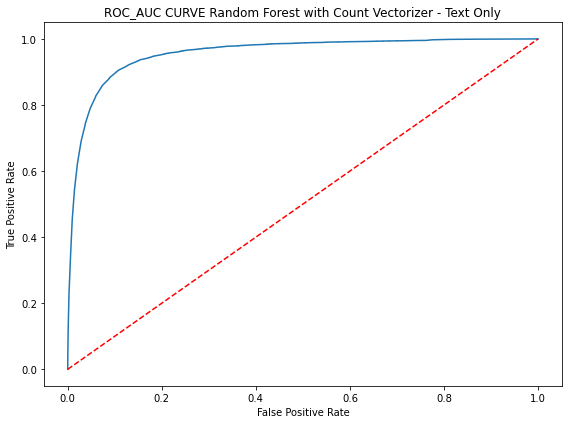

In [76]:
y_pred_proba5 = rfcv.predict_proba(X_test5)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test5,  y_pred_proba5)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr5,tpr5)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Random Forest with Count Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with Count Vectorizer TextOnly.png')

# Random Forest - Count Vectorizer All Features

In [77]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2403083902.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2403083902.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [78]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=0.25, random_state=12)

In [79]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'].head(1000))
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].head(1000).values[:, None]
sentiment = scaled_features_df['sentiment'].head(1000).values[:, None]
reading_level = scaled_features_df['flesch_kincaid'].head(1000)[:, None]
repetition = scaled_features_df['repetition'].head(1000)[:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_param = hstack((third, sentiment))

y_param = df['class'].head(1000)

C:\Users\betha\AppData\Local\Temp\ipykernel_10488\171635267.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'].head(1000)[:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\171635267.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'].head(1000)[:, None]


In [80]:
X_train_param, X_test_param, y_train_param, y_test_param = train_test_split(X_param, y_param, test_size=0.25, random_state=12)

In [81]:

n_est = [int(n) for n in np.logspace(start=2.5, stop=4, num=5)]
depth = [int(x) for x in np.linspace(10, 100, num = 10)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train_param, y_train_param)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_estimators': [316, 749, 1778, 4216, 10000]})

In [82]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.8386666666666667
Best Parameters: {'max_depth': 90, 'n_estimators': 4216}


In [83]:
rfcvi = RandomForestClassifier(n_estimators = 4216 , max_depth = 90)
rfcvi.fit(X_train6, y_train6)

RandomForestClassifier(max_depth=90, n_estimators=4216)

In [84]:
y_train_pred_rfcvi = rfcvi.predict(X_train6)
y_pred6 = rfcvi.predict(X_test6)

In [85]:
training_accuracy_rfcvi = rfcvi.score(X_train6, y_train6)
test_accuracy_rfcvi = rfcvi.score(X_test6, y_pred6)

In [86]:
print("Accuracy on training data: {:2f}".format(training_accuracy_rfcvi))
print("Accuracy on test data:     {:2f}".format(test_accuracy_rfcvi))

Accuracy on training data: 0.918649
Accuracy on test data:     1.000000


In [87]:
from sklearn import tree, metrics
accuracy_rfcvi = metrics.accuracy_score(y_test6,y_pred6)
balanced_accuracy_rfcvi = metrics.balanced_accuracy_score(y_test6,y_pred6)
precision_rfcvi = metrics.precision_score(y_test6,y_pred6, pos_label = 1)
recall_rfcvi = metrics.recall_score(y_test6,y_pred6, pos_label = 1)
f1_rfcvi = metrics.f1_score(y_test6, y_pred6, pos_label = 1)
roc_auc_rfcvi = metrics.roc_auc_score(y_test6, y_pred6)
print("Accuracy:", accuracy_rfcvi)
print("Balanced accuracy:", balanced_accuracy_rfcvi)
print('Precision score' , precision_rfcvi)
print('Recall score' , recall_rfcvi)
print('F1 score' , f1_rfcvi)
print('ROC_AUC Score' , roc_auc_rfcvi)


Accuracy: 0.8585144708944547
Balanced accuracy: 0.8584517221527499
Precision score 0.8945827789393651
Recall score 0.8123726999689301
F1 score 0.8514980460269214
ROC_AUC Score 0.8584517221527498


In [88]:
from sklearn.metrics import confusion_matrix
tn_rfcvi, fp_rfcvi, fn_rfcvi, tp_rfcvi = confusion_matrix(y_test6, y_pred6).ravel()
print(f'True Suicide: {tp_rfcvi}')
print(f'False Suicide: {fp_rfcvi}')
print(f'True Non-Suicide: {tn_rfcvi}')
print(f'False Non-Suicide: {fn_rfcvi}')

True Suicide: 23532
False Suicide: 2773
True Non-Suicide: 26273
False Non-Suicide: 5435


In [89]:
pd.DataFrame(confusion_matrix(y_test6, y_pred6), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26273,2773
Actual Suicide,5435,23532


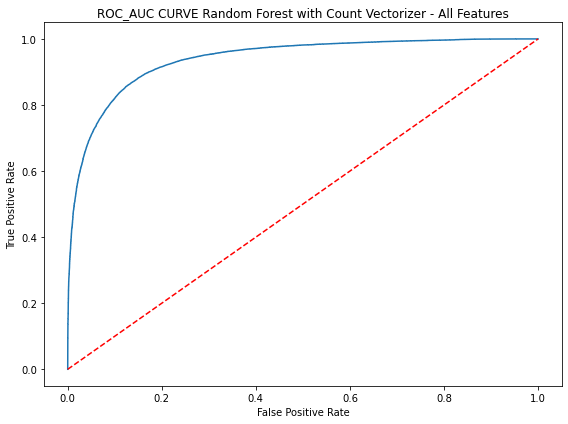

In [90]:
y_pred_proba6 = rfcvi.predict_proba(X_test6)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test6,  y_pred_proba6)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr6,tpr6)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Random Forest with Count Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with Count Vectorizer All Features.png')

# Random Forest - TF-IDF - Text Only

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X_tfid1 = vectorizor_tfid.fit_transform(df['text'])
X_tfid1 = X_tfid1.tocsc() 
y_tfid1 = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [92]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(X_tfid1, y_tfid1, test_size=0.25, random_state=12)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X_params = vectorizor_tfid.fit_transform(df['text'].head(1000))
X_params = X_params.tocsc() 
y_params = df['class'].head(1000)

In [94]:
X_train_params7, X_test_params7, y_train_params7, y_test_params7 = train_test_split(X_params, y_params, test_size=0.25, random_state=12)

In [95]:

n_est = [int(n) for n in np.logspace(start=1.5, stop=2.5, num=5)]
depth = [int(x) for x in np.linspace(20, 100, num = 5)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train_params7, y_train_params7)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [20, 40, 60, 80, 100],
                         'n_estimators': [31, 56, 100, 177, 316]})

In [99]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.86
Best Parameters: {'max_depth': 40, 'n_estimators': 100}


In [100]:
rf_tfidf = RandomForestClassifier(max_depth = 40 , n_estimators = 100)
rf_tfidf.fit(X_train7, y_train7)


RandomForestClassifier(max_depth=40)

In [101]:
y_train_pred7 = rf_tfidf.predict(X_train7)
y_pred7 = rf_tfidf.predict(X_test7)

In [102]:
training_accuracy_rf_tfid = rf_tfidf.score(X_train7, y_train7)
test_accuracy_rf_tfid = rf_tfidf.score(X_test7, y_test7)

In [103]:
print("Accuracy on training data: {:2f}".format(training_accuracy_rf_tfid))
print("Accuracy on test data:     {:2f}".format(test_accuracy_rf_tfid))

Accuracy on training data: 0.860627
Accuracy on test data:     0.835278


In [104]:
from sklearn import tree, metrics

accuracy_rf_tfidf = metrics.accuracy_score(y_test7,y_pred7)
balanced_accuracy_rf_tfidf = metrics.balanced_accuracy_score(y_test7,y_pred7)
precision_rf_tfidf = metrics.precision_score(y_test7,y_pred7, pos_label = 1)
recall_rf_tfidf = metrics.recall_score(y_test7,y_pred7, pos_label = 1)
f1_rf_tfidf = metrics.f1_score(y_test7, y_pred7, pos_label = 1)
roc_auc_rf_tfidf = metrics.roc_auc_score(y_test7, y_pred7)
print("Accuracy:", accuracy_rf_tfidf)
print("Balanced accuracy:", balanced_accuracy_rf_tfidf)
print('Precision score' , precision_rf_tfidf)
print('Recall score' , recall_rf_tfidf)
print('F1 score' , f1_rf_tfidf)
print('ROC_AUC Score' , roc_auc_rf_tfidf)



Accuracy: 0.8352782996914485
Balanced accuracy: 0.8351730208843904
Precision score 0.8962237191263523
Recall score 0.7578623951392964
F1 score 0.8212562193707681
ROC_AUC Score 0.8351730208843903


In [105]:
from sklearn.metrics import confusion_matrix
tn_rf_tfid, fp_rf_tfid, fn_rf_tfid, tp_rf_tfid = confusion_matrix(y_test7, y_pred7).ravel()
print(f'True Suicide: {tp_rf_tfid}')
print(f'False Suicide: {fp_rf_tfid}')
print(f'True Non-Suicide: {tn_rf_tfid}')
print(f'False Non-Suicide: {fn_rf_tfid}')

True Suicide: 21953
False Suicide: 2542
True Non-Suicide: 26504
False Non-Suicide: 7014


In [106]:
pd.DataFrame(confusion_matrix(y_test7, y_pred7), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26504,2542
Actual Suicide,7014,21953


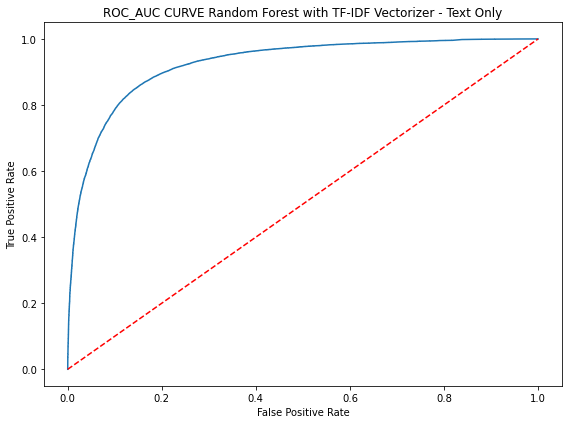

In [107]:
y_pred_proba7 = rf_tfidf.predict_proba(X_test7)[::,1]
fpr7, tpr7, _ = metrics.roc_curve(y_test7,  y_pred_proba7)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr7,tpr7)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Random Forest with TF-IDF Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with TF-IDF_text_only.png')

# Random Forest - TF-IDF All Features

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix8 = vectorizor_tfid.fit_transform(df['text'])
text_matrix8 = text_matrix8.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix8, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_tfid8 = hstack((third, sentiment))

y_tfid8 = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2780035948.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2780035948.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [109]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(X_tfid8, y_tfid8, test_size=0.25, random_state=12)

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix8 = vectorizor_tfid.fit_transform(df['text'].head(1000))
text_matrix8 = text_matrix8.tocsc() 
length = scaled_features_df['length'].head(1000).values[:, None]
sentiment = scaled_features_df['sentiment'].head(1000).values[:, None]
reading_level = scaled_features_df['flesch_kincaid'].head(1000)[:, None]
repetition = scaled_features_df['repetition'].head(1000)[:, None]
first = hstack((text_matrix8, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_param8 = hstack((third, sentiment))

y_param8 = df['class'].head(1000)


C:\Users\betha\AppData\Local\Temp\ipykernel_10488\1331152607.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'].head(1000)[:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\1331152607.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'].head(1000)[:, None]


In [111]:
X_train_param8, X_test_param8, y_train_param8, y_test_param8 = train_test_split(X_param8, y_param8, test_size=0.25, random_state=12)

In [118]:

n_est = [int(n) for n in np.logspace(start=1.6, stop=3.9, num=5)]
depth = [int(x) for x in np.linspace(10, 100, num = 6)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestClassifier(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train_param8, y_train_param8)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1519),
             param_grid={'max_depth': [10, 28, 46, 64, 82, 100],
                         'n_estimators': [39, 149, 562, 2113, 7943]})

In [119]:

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))


Best Score:0.844
Best Parameters: {'max_depth': 46, 'n_estimators': 2113}


In [120]:
rf_tfidfi = RandomForestClassifier(max_depth = 46, n_estimators = 2113)
rf_tfidfi.fit(X_train8, y_train8)

RandomForestClassifier(max_depth=46, n_estimators=2113)

In [121]:
y_train_pred8 = rf_tfidfi.predict(X_train8)
y_pred8 = rf_tfidfi.predict(X_test8)

In [122]:
training_accuracy_rf_tfidi = rf_tfidfi.score(X_train8, y_train8)
test_accuracy_rf_tfidi = rf_tfidfi.score(X_test8, y_test8)

In [123]:
print("Accuracy on training data: {:2f}".format(training_accuracy_rf_tfidi))
print("Accuracy on test data:     {:2f}".format(test_accuracy_rf_tfidi))

Accuracy on training data: 0.870693
Accuracy on test data:     0.839036


In [124]:

accuracy_rf_tfidfi = metrics.accuracy_score(y_test8,y_pred8)
balanced_accuracy_rf_tfidfi = metrics.balanced_accuracy_score(y_test8,y_pred8)
precision_rf_tfidfi = metrics.precision_score(y_test8,y_pred8, pos_label = 1)
recall_rf_tfidfi = metrics.recall_score(y_test8,y_pred8, pos_label = 1)
f1_rf_tfidfi = metrics.f1_score(y_test8, y_pred8, pos_label = 1)
roc_auc_rf_tfidfi = metrics.roc_auc_score(y_test8, y_pred8)
print("Accuracy:", accuracy_rf_tfidfi)
print("Balanced accuracy:", balanced_accuracy_rf_tfidfi)
print('Precision score' , precision_rf_tfidfi)
print('Recall score' , recall_rf_tfidfi)
print('F1 score' , f1_rf_tfidfi)
print('ROC_AUC Score' , roc_auc_rf_tfidfi)


Accuracy: 0.8390360781204212
Balanced accuracy: 0.8389440453174508
Precision score 0.8916556925655453
Recall score 0.7713605136879897
F1 score 0.8271572946359161
ROC_AUC Score 0.8389440453174507


In [125]:
from sklearn.metrics import confusion_matrix
tn_rf_tfidi, fp_rf_tfidi, fn_rf_tfidi, tp_rf_tfidi = confusion_matrix(y_test8, y_pred8).ravel()
print(f'True Suicide: {tp_rf_tfidi}')
print(f'False Suicide: {fp_rf_tfidi}')
print(f'True Non-Suicide: {tn_rf_tfidi}')
print(f'False Non-Suicide: {fn_rf_tfidi}')

True Suicide: 22344
False Suicide: 2715
True Non-Suicide: 26331
False Non-Suicide: 6623


In [126]:
pd.DataFrame(confusion_matrix(y_test8, y_pred8), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,26331,2715
Actual Suicide,6623,22344


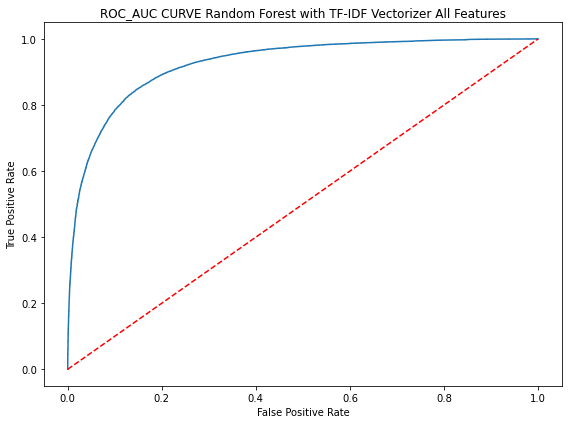

In [127]:
y_pred_proba8 = rf_tfidfi.predict_proba(X_test8)[::,1]
fpr8, tpr8, _ = metrics.roc_curve(y_test8,  y_pred_proba8)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr8,tpr8)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Random Forest with TF-IDF Vectorizer All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Curve Random Forest with TF-IDF.ALL_Features.png')

# Logistic Regression - Count Vectorizer - Text Only

In [128]:
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizer.fit_transform(df['clean_text'])
X = X.tocsc() 
y = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [129]:
X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=0.25, random_state=12)

In [130]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train9, y_train9)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [131]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr = LogisticRegression(random_state = 0)
lr_cv = GridSearchCV(lr, param_grid, cv = 5)
lr_cv.fit(X_train9, y_train9)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [132]:
print("Best Score:" + str(lr_cv.best_score_))
print("Best Parameters: " + str(lr_cv.best_params_))

Best Score:0.9318934088506978
Best Parameters: {'C': 1.0}


In [133]:
lr = LogisticRegression(C = 1.0)
lr.fit(X_train9, y_train9)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [134]:
y_train_pred = lr.predict(X_train9)
y_pred9 = lr.predict(X_test9)

In [135]:
training_accuracy_lrcv = lr.score(X_train9, y_train9)
test_accuracy_lrcv = lr.score(X_test9, y_test9)

In [136]:
print("Accuracy on training data: {:2f}".format(training_accuracy_lrcv))
print("Accuracy on test data:     {:2f}".format(test_accuracy_lrcv))

Accuracy on training data: 0.987284
Accuracy on test data:     0.935015


In [137]:
from sklearn import tree, metrics

accuracy_lrcv = metrics.accuracy_score(y_test9,y_pred9)
balanced_accuracy_lrcv = metrics.balanced_accuracy_score(y_test9,y_pred9)
precision_lrcv = metrics.precision_score(y_test9,y_pred9, pos_label = 1)
recall_lrcv = metrics.recall_score(y_test9,y_pred9, pos_label = 1)
f1_lrcv = metrics.f1_score(y_test9, y_pred9, pos_label = 1)
roc_auc_lrcv = metrics.roc_auc_score(y_test9, y_pred9)
print("Accuracy:", accuracy_lrcv)
print("Balanced accuracy:", balanced_accuracy_lrcv)
print('Precision score' , precision_lrcv)
print('Recall score' , recall_lrcv)
print('F1 score' , f1_lrcv)
print('ROC_AUC Score' , roc_auc_lrcv)


Accuracy: 0.9350145657007912
Balanced accuracy: 0.9349946805319436
Precision score 0.9479466666666667
Recall score 0.9203921704008009
F1 score 0.9339662299446508
ROC_AUC Score 0.9349946805319436


In [138]:
from sklearn.metrics import confusion_matrix
tn_lrcv, fp_lrcv, fn_lrcv, tp_lrcv = confusion_matrix(y_test9, y_pred9).ravel()
print(f'True Suicide: {tp_lrcv}')
print(f'False Suicide: {fp_lrcv}')
print(f'True Non-Suicide: {tn_lrcv}')
print(f'False Non-Suicide: {fn_lrcv}')

True Suicide: 26661
False Suicide: 1464
True Non-Suicide: 27582
False Non-Suicide: 2306


In [139]:
pd.DataFrame(confusion_matrix(y_test9, y_pred9), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,27582,1464
Actual Suicide,2306,26661


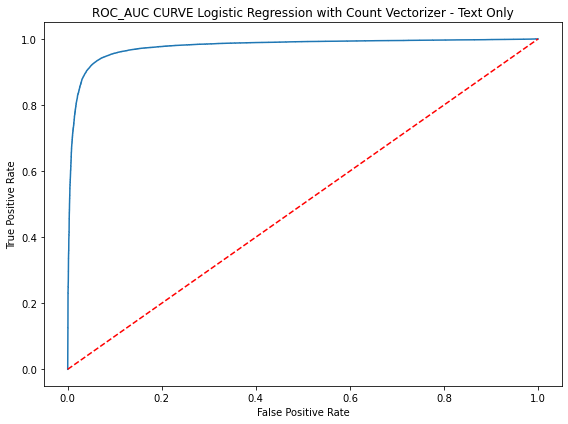

In [140]:
y_pred_proba9 = lr.predict_proba(X_test9)[::,1]
fpr9, tpr9, _ = metrics.roc_curve(y_test9,  y_pred_proba9)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr9,tpr9)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with Count Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with Count Vectorizer_TextOnly.png')

# Logistic Regression - Count Vectorizer - All Features

In [141]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix = vectorizer.fit_transform(df['clean_text'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2403083902.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\2403083902.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [142]:
X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=0.25, random_state=12)

In [143]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr = LogisticRegression(random_state = 0)
lr_cv = GridSearchCV(lr, param_grid, cv = 5)
lr_cv.fit(X_train10, y_train10)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [144]:
print("Best Score:" + str(lr_cv.best_score_))
print("Best Parameters: " + str(lr_cv.best_params_))

Best Score:0.9320887713571644
Best Parameters: {'C': 1.0}


In [145]:
lrcvi = LogisticRegression(C = 1.0)
lrcvi.fit(X_train10, y_train10)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [146]:
y_train_pred10 = lrcvi.predict(X_train10)
y_pred10 = lrcvi.predict(X_test10)

In [147]:
training_accuracy_lrcvi = lrcvi.score(X_train10, y_train10)
test_accuracy_lrcvi = lrcvi.score(X_test10, y_test10)

In [148]:
print("Accuracy on training data: {:2f}".format(training_accuracy_lrcvi))
print("Accuracy on test data:     {:2f}".format(test_accuracy_lrcvi))

Accuracy on training data: 0.985158
Accuracy on test data:     0.935601


In [149]:
accuracy_lrcvi = metrics.accuracy_score(y_test10,y_pred10)
balanced_accuracy_lrcvi = metrics.balanced_accuracy_score(y_test10,y_pred10)
precision_lrcvi = metrics.precision_score(y_test10,y_pred10, pos_label = 1)
recall_lrcvi = metrics.recall_score(y_test10,y_pred10, pos_label = 1)
f1_lrcvi = metrics.f1_score(y_test10, y_pred10, pos_label = 1)
roc_auc_lrcvi = metrics.roc_auc_score(y_test10, y_pred10)
print("Accuracy:", accuracy_lrcvi)
print("Balanced accuracy:", balanced_accuracy_lrcvi)
print('Precision score' , precision_lrcvi)
print('Recall score' , recall_lrcvi)
print('F1 score' , f1_lrcvi)
print('ROC_AUC Score' , roc_auc_lrcvi)


Accuracy: 0.9356006412355852
Balanced accuracy: 0.9355816021983869
Precision score 0.947977699655552
Recall score 0.9216004418821417
F1 score 0.9346029967791626
ROC_AUC Score 0.9355816021983869


In [150]:
from sklearn.metrics import confusion_matrix
tn_lrcvi, fp_lrcvi, fn_lrcvi, tp_lrcvi = confusion_matrix(y_test10, y_pred10).ravel()
print(f'True Suicide: {tp_lrcvi}')
print(f'False Suicide: {fp_lrcvi}')
print(f'True Non-Suicide: {tn_lrcvi}')
print(f'False Non-Suicide: {fn_lrcvi}')

True Suicide: 26696
False Suicide: 1465
True Non-Suicide: 27581
False Non-Suicide: 2271


In [151]:
pd.DataFrame(confusion_matrix(y_test10, y_pred10), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,27581,1465
Actual Suicide,2271,26696


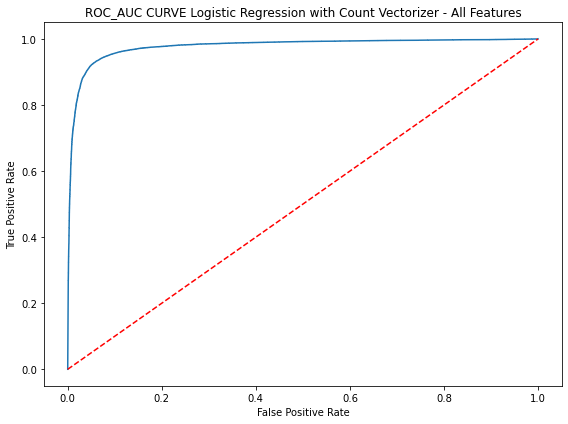

In [152]:
y_pred_proba10 = lrcvi.predict_proba(X_test10)[::,1]
fpr10, tpr10, _ = metrics.roc_curve(y_test10,  y_pred_proba10)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr10,tpr10)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with Count Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with Count Vectorizer All Features.png')

# Logistic Regression - TF-IDF - Text Only

In [153]:
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
X = vectorizor_tfid.fit_transform(df['text'])
X_tfid11 = X.tocsc() 

y_tfid11 = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [154]:
X_train11, X_test11, y_train11, y_test11 = train_test_split(X_tfid11, y_tfid11, test_size=0.25, random_state=12)

In [155]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr_tfid = LogisticRegression(random_state = 0)
lr_tfid_cv = GridSearchCV(lr_tfid, param_grid, cv = 5)
lr_tfid_cv.fit(X_train11, y_train11)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [156]:
print("Best Score:" + str(lr_tfid_cv.best_score_))
print("Best Parameters: " + str(lr_tfid_cv.best_params_))

Best Score:0.9394550632906251
Best Parameters: {'C': 10}


In [157]:
lr_tfid = LogisticRegression(C = 10)
lr_tfid.fit(X_test11, y_test11)

LogisticRegression(C=10)

In [158]:
y_train_pred11 = lr_tfid.predict(X_train11)
y_pred11 = lr_tfid.predict(X_test11)

In [159]:
training_accuracy = lr_tfid.score(X_train11, y_train11)
test_accuracy = lr_tfid.score(X_test11, y_test11)

In [160]:
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.933405
Accuracy on test data:     0.995449


In [161]:
accuracy_lr_tfidf = metrics.accuracy_score(y_test11,y_pred11)
balanced_accuracy_lr_tfidf = metrics.balanced_accuracy_score(y_test11,y_pred11)
precision_lr_tfidf = metrics.precision_score(y_test11,y_pred11, pos_label = 1)
recall_lr_tfidf = metrics.recall_score(y_test11,y_pred11, pos_label = 1)
f1_lr_tfidf = metrics.f1_score(y_test11, y_pred11, pos_label = 1)
roc_auc_lr_tfidf = metrics.roc_auc_score(y_test11, y_pred11)
print("Accuracy:", accuracy_lr_tfidf)
print("Balanced accuracy:", balanced_accuracy_lr_tfidf)
print('Precision score' , precision_lr_tfidf)
print('Recall score' , recall_lr_tfidf)
print('F1 score' , f1_lr_tfidf)
print('ROC_AUC Score' , roc_auc_lr_tfidf)



Accuracy: 0.9954492958474824
Balanced accuracy: 0.9954500385595976
Precision score 0.9948963757370943
Recall score 0.9959954430904132
F1 score 0.9954456060449229
ROC_AUC Score 0.9954500385595976


In [162]:
from sklearn.metrics import confusion_matrix
tn_lr_tfid, fp_lr_tfid, fn_lr_tfid, tp_lr_tfid = confusion_matrix(y_test11, y_pred11).ravel()
print(f'True Suicide: {tp_lr_tfid}')
print(f'False Suicide: {fp_lr_tfid}')
print(f'True Non-Suicide: {tn_lr_tfid}')
print(f'False Non-Suicide: {fn_lr_tfid}')

True Suicide: 28851
False Suicide: 148
True Non-Suicide: 28898
False Non-Suicide: 116


In [163]:
pd.DataFrame(confusion_matrix(y_test11, y_pred11), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,28898,148
Actual Suicide,116,28851


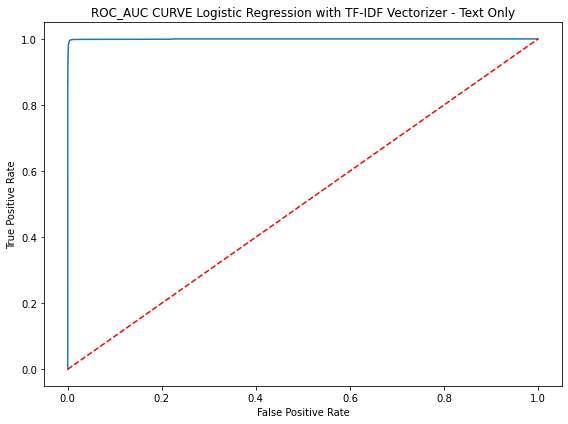

In [164]:
y_pred_proba11 = lr_tfid.predict_proba(X_test11)[::,1]
fpr11, tpr11, _ = metrics.roc_curve(y_test11,  y_pred_proba11)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr11,tpr11)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer - Text Only")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer_Text_Only.png')

# Logistic Regression - TF-IDF - All Features

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=3, ngram_range = (1,2), stop_words = STOP_WORDS)
text_matrix12 = vectorizor_tfid.fit_transform(df['text'])
text_matrix12 = text_matrix12.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix12, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_tfid12 = hstack((third, sentiment))

y_tfid12 = df['class']

C:\Users\betha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\710736219.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\betha\AppData\Local\Temp\ipykernel_10488\710736219.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [166]:
X_train12, X_test12, y_train12, y_test12 = train_test_split(X_tfid12, y_tfid12, test_size=0.25, random_state=12)

In [167]:
#penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = {'C' : c_values}
lr_tfid = LogisticRegression(random_state = 0)
lr_tfid_cvi = GridSearchCV(lr_tfid, param_grid, cv = 5)
lr_tfid_cvi.fit(X_train12, y_train12)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [168]:
print("Best Score:" + str(lr_tfid_cvi.best_score_))
print("Best Parameters: " + str(lr_tfid_cvi.best_params_))

Best Score:0.9396216982549674
Best Parameters: {'C': 10}


In [169]:
lr_tfidi = LogisticRegression(C = 10)
lr_tfidi.fit(X_test12, y_test12)

C:\Users\betha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [170]:
y_train_pred12 = lr_tfidi.predict(X_train12)
y_pred12 = lr_tfidi.predict(X_test12)

In [171]:
training_accuracy = lr_tfidi.score(X_train12, y_train12)
test_accuracy = lr_tfidi.score(X_test12, y_test12)

In [172]:
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.933451
Accuracy on test data:     0.995432


In [173]:
accuracy_lr_tfidfi = metrics.accuracy_score(y_test12,y_pred12)
balanced_accuracy_lr_tfidfi = metrics.balanced_accuracy_score(y_test12,y_pred12)
precision_lr_tfidfi = metrics.precision_score(y_test12,y_pred12, pos_label = 1)
recall_lr_tfidfi = metrics.recall_score(y_test12,y_pred12, pos_label = 1)
f1_lr_tfidfi = metrics.f1_score(y_test12, y_pred12, pos_label = 1)
roc_auc_lr_tfidfi = metrics.roc_auc_score(y_test12, y_pred12)
print("Accuracy:", accuracy_lr_tfidfi)
print("Balanced accuracy:", balanced_accuracy_lr_tfidfi)
print('Precision score' , precision_lr_tfidfi)
print('Recall score' , recall_lr_tfidfi)
print('F1 score' , f1_lr_tfidfi)
print('ROC_AUC Score' , roc_auc_lr_tfidfi)


Accuracy: 0.9954320583317532
Balanced accuracy: 0.9954328244853705
Precision score 0.9948620689655172
Recall score 0.9959954430904132
F1 score 0.9954284334190142
ROC_AUC Score 0.9954328244853704


In [174]:
from sklearn.metrics import confusion_matrix
tn_lr_tfidi, fp_lr_tfidi, fn_lr_tfidi, tp_lr_tfidi = confusion_matrix(y_test12, y_pred12).ravel()
print(f'True Suicide: {tp_lr_tfidi}')
print(f'False Suicide: {fp_lr_tfidi}')
print(f'True Non-Suicide: {tn_lr_tfidi}')
print(f'False Non-Suicide: {fn_lr_tfidi}')

True Suicide: 28851
False Suicide: 149
True Non-Suicide: 28897
False Non-Suicide: 116


In [175]:
pd.DataFrame(confusion_matrix(y_test12, y_pred12), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,28897,149
Actual Suicide,116,28851


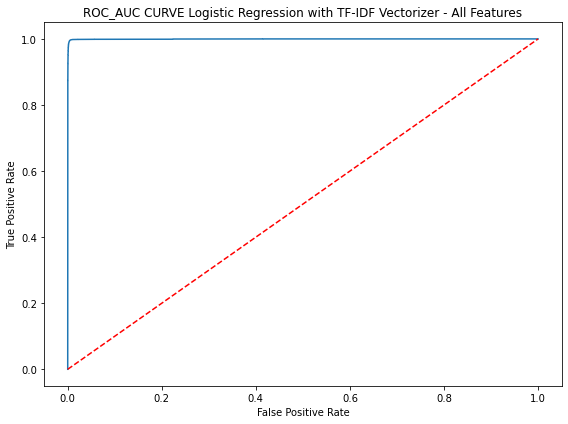

In [176]:
y_pred_proba12 = lr_tfidi.predict_proba(X_test12)[::,1]
fpr12, tpr12, _ = metrics.roc_curve(y_test12,  y_pred_proba12)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr12,tpr12)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer - All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Logistic Regression with TF-IDF Vectorizer_All_Features.png')

# Evaluate the models

In [177]:
from tabulate import tabulate
d = [ ["Naive Bayes (Count Vectorizer - Text Only)",round(accuracy_nbcv, 3), round(precision_nbcv, 3), round(recall_nbcv, 3), round(f1_nbcv, 3), round(roc_auc_nbcv, 3)], 
     ["Naive Bayes (Count Vectorizer - All Features)",round(accuracy_nbcvi, 3), round(precision_nbcvi, 3), round(recall_nbcvi, 3), round(f1_nbcvi, 3), round(roc_auc_nbcvi, 3)], 
     
     ["Naive Bayes (TF-IDF - Text Only)",round(accuracy_nb_tfidf, 3), round(precision_nb_tfidf, 3), round(recall_nb_tfidf, 3), round(f1_nb_tfidf, 3), round(roc_auc_nb_tfidf, 3)],
    ["Naive Bayes (TF-IDF - All Features)",round(accuracy_nb_tfidfi, 3), round(precision_nb_tfidfi, 3), round(recall_nb_tfidfi, 3), round(f1_nb_tfidfi, 3), round(roc_auc_nb_tfidfi, 3)], ["", "", "" ,"", "", ""],
    ["Random Forest (Count Vectorizer - Text Only)",round(accuracy_rfcv, 3), round(precision_rfcv, 3), round(recall_rfcv, 3), round(f1_rfcv, 3), round(roc_auc_rfcv, 3)], 
    ["Random Forest (Count Vectorizer - All Features)",round(accuracy_rfcvi, 3), round(precision_rfcvi, 3), round(recall_rfcvi, 3), round(f1_rfcvi, 3), round(roc_auc_rfcvi, 3)], 
    ["Random Forest (TF-IDF - Text Only)",round(accuracy_rf_tfidf, 3), round(precision_rf_tfidf, 3), round(recall_rf_tfidf, 3), round(f1_rf_tfidf, 3), round(roc_auc_rf_tfidf, 3)], 
    ["Random Forest (TF-IDF - All Features)",round(accuracy_rf_tfidfi, 3), round(precision_rf_tfidfi, 3), round(recall_rf_tfidfi, 3), round(f1_rf_tfidfi, 3), round(roc_auc_rf_tfidfi, 3)], ["", "", "" ,"", "", ""],
    ["Logistic Regression (Count Vectorizer - Text Only)",round(accuracy_lrcv, 3), round(precision_lrcv, 3), round(recall_lrcv, 3), round(f1_lrcv, 3), round(roc_auc_lrcv, 3)], 
    ["Logistic Regression (Count Vectorizer - All Features)",round(accuracy_lrcvi, 3), round(precision_lrcvi, 3), round(recall_lrcvi, 3), round(f1_lrcvi, 3), round(roc_auc_lrcvi, 3)], 
    ["Logistic Regression (TF-IDF - Text Only)",round(accuracy_lr_tfidf, 3), round(precision_lr_tfidf, 3), round(recall_lr_tfidf, 3), round(f1_lr_tfidf, 3), round(roc_auc_lr_tfidf, 3)], 
    ["Logistic Regression (TF-IDF - All Features)",round(accuracy_lr_tfidfi, 3), round(precision_lr_tfidfi, 3), round(recall_lr_tfidfi, 3), round(f1_lr_tfidfi, 3), round(roc_auc_lr_tfidfi, 3)], ["", "", "" ,"", "", ""]]
print(" ")
print(" ")
datalist2 = tabulate(d, headers=["   Model  ", "Accuracy Score", "Precision Score", "Recall Score", "F1 Score", "ROC_AUC Score"])
print(datalist2)

 
 
   Model                                               Accuracy Score    Precision Score    Recall Score    F1 Score    ROC_AUC Score
-----------------------------------------------------  ----------------  -----------------  --------------  ----------  ---------------
Naive Bayes (Count Vectorizer - Text Only)             0.919             0.89               0.956           0.922       0.919
Naive Bayes (Count Vectorizer - All Features)          0.923             0.903              0.947           0.924       0.923
Naive Bayes (TF-IDF - Text Only)                       0.921             0.888              0.962           0.924       0.921
Naive Bayes (TF-IDF - All Features)                    0.925             0.899              0.956           0.927       0.925

Random Forest (Count Vectorizer - Text Only)           0.899             0.893              0.905           0.899       0.899
Random Forest (Count Vectorizer - All Features)        0.859             0.895              0.8

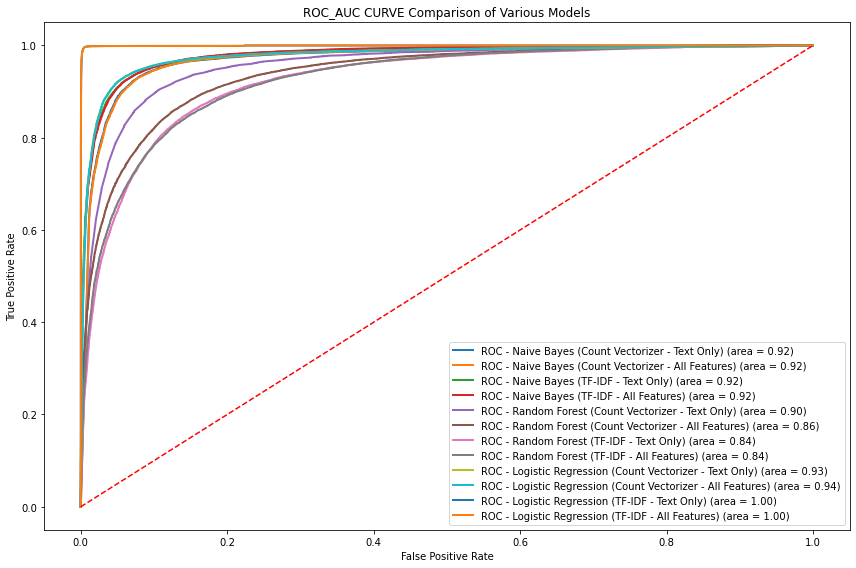

In [178]:
plt.figure(figsize=(12,8))

plt.plot(fpr1, tpr1, lw=2, label='ROC - Naive Bayes (Count Vectorizer - Text Only)' + ' (area = %0.2f)' % roc_auc_nbcv)
plt.plot(fpr2, tpr2, lw=2, label='ROC - Naive Bayes (Count Vectorizer - All Features)' + ' (area = %0.2f)' % roc_auc_nbcvi)
plt.plot(fpr3, tpr3, lw=2, label='ROC - Naive Bayes (TF-IDF - Text Only)' + ' (area = %0.2f)' % roc_auc_nb_tfidf)
plt.plot(fpr4, tpr4, lw=2, label='ROC - Naive Bayes (TF-IDF - All Features)' + ' (area = %0.2f)' % roc_auc_nb_tfidfi)
plt.plot(fpr5, tpr5, lw=2, label='ROC - Random Forest (Count Vectorizer - Text Only)' + ' (area = %0.2f)' % roc_auc_rfcv)
plt.plot(fpr6, tpr6, lw=2, label='ROC - Random Forest (Count Vectorizer - All Features)' + ' (area = %0.2f)' % roc_auc_rfcvi)
plt.plot(fpr7, tpr7, lw=2, label='ROC - Random Forest (TF-IDF - Text Only)' + ' (area = %0.2f)' % roc_auc_rf_tfidf)
plt.plot(fpr8, tpr8, lw=2, label='ROC - Random Forest (TF-IDF - All Features)' + ' (area = %0.2f)' % roc_auc_rf_tfidfi)
plt.plot(fpr9, tpr9, lw=2, label='ROC - Logistic Regression (Count Vectorizer - Text Only)' + ' (area = %0.2f)' % roc_auc_lrcv)
plt.plot(fpr10, tpr10, lw=2, label='ROC - Logistic Regression (Count Vectorizer - All Features)' + ' (area = %0.2f)' % roc_auc_lrcvi)
plt.plot(fpr11, tpr11, lw=2, label='ROC - Logistic Regression (TF-IDF - Text Only)' + ' (area = %0.2f)' % roc_auc_lr_tfidf)
plt.plot(fpr12, tpr12, lw=2, label='ROC - Logistic Regression (TF-IDF - All Features)' + ' (area = %0.2f)' % roc_auc_lr_tfidfi)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Comparison of Various Models")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC_AUC CURVE Model Comparison.png')

In [179]:
d1 = [ ["Naive Bayes (Count Vectorizer - Text Only)",tp_nbcv, fp_nbcv, tn_nbcv, fn_nbcv], 
     ["Naive Bayes (Count Vectorizer - All Features)",tp_nbcvi, fp_nbcvi, tn_nbcvi, fn_nbcvi],      
     ["Naive Bayes (TF-IDF - Text Only)",tp_nb_tfidf, fp_nb_tfidf, tn_nb_tfidf, fn_nb_tfidf],
    ["Naive Bayes (TF-IDF - All Features)",tp_nb_tfidfi, fp_nb_tfidfi, tn_nb_tfidfi, fn_nb_tfidfi], ["", "", "" ,"", "", ""],
    ["Random Forest (Count Vectorizer - Text Only)",tp_rfcv, tn_rfcv, fp_rfcv, fn_rfcv], 
    ["Random Forest (Count Vectorizer - All Features)",tp_rfcvi, tn_rfcvi, tn_rfcvi, fn_rfcvi], 
    ["Random Forest (TF-IDF - Text Only)",tp_rf_tfid, fp_rf_tfid, tn_rf_tfid, fn_rf_tfid], 
    ["Random Forest (TF-IDF - All Features)",tp_rf_tfidi, fp_rf_tfidi, tn_rf_tfidi, fn_rf_tfidi], ["", "", "" ,"", "", ""],
    ["Logistic Regression (Count Vectorizer - Text Only)",tp_lrcv, fp_lrcv, tn_lrcv, fn_lrcv], 
    ["Logistic Regression (Count Vectorizer - All Features)",tp_lrcvi, fp_lrcvi, tn_lrcvi, fn_lrcvi], 
    ["Logistic Regression (TF-IDF - Text Only)",tp_lr_tfid, fp_lr_tfid, tn_lr_tfid, fn_lr_tfid], 
    ["Logistic Regression (TF-IDF - All Features)",tp_lr_tfidi, fp_lr_tfidi, tn_lr_tfidi, fn_lr_tfidi], ["", "", "" ,"", "", ""]]
print(" ")
print(" ")
datalist3 = tabulate(d1, headers=["   Model  ", "True Positive", "False Positive", "True Negative", "False Negative"])
print(datalist3)

 
 
   Model                                               True Positive    False Positive    True Negative    False Negative
-----------------------------------------------------  ---------------  ----------------  ---------------  ----------------
Naive Bayes (Count Vectorizer - Text Only)             27685            3409              25637            1282
Naive Bayes (Count Vectorizer - All Features)          27437            2960              26086            1530
Naive Bayes (TF-IDF - Text Only)                       27865            3500              25546            1102
Naive Bayes (TF-IDF - All Features)                    27703            3108              25938            1264

Random Forest (Count Vectorizer - Text Only)           26216            25917             3129             2751
Random Forest (Count Vectorizer - All Features)        23532            26273             26273            5435
Random Forest (TF-IDF - Text Only)                     21953            2542 

# Look at Mis-Labeled Examples

In [181]:
lr_tfid = LogisticRegression(C = 10)
lr_tfid.fit(X_test11, y_test11)

LogisticRegression(C=10)

In [182]:
dict1 = {'predict_proba':lr_tfid.predict_proba(X_test11)[:, 1], 'prediction' : lr_tfid.predict(X_test11), 'actual' :y_test11}

In [183]:
df_preds = pd.DataFrame(dict1)

In [184]:
df_preds['sum'] = df_preds['prediction'] + df_preds['actual']
mixed = df_preds[df_preds['sum'] == 1].reset_index()
mixed.head(10)

,index,predict_proba,prediction,actual,sum
0,52828,0.642519,1,0,1
1,18617,0.528270,1,0,1
2,17450,0.810197,1,0,1
3,101855,0.616240,1,0,1
4,159920,0.294795,0,1,1
5,74266,0.546219,1,0,1
6,58336,0.497173,0,1,1
7,214213,0.444117,0,1,1
8,176695,0.610840,1,0,1
9,15840,0.576866,1,0,1


In [186]:
mixed['string'] = ''

In [187]:
for i in range(len(mixed)):
    mixed['string'].iloc[i] = df['text'].iloc[mixed['index'].iloc[i]]

C:\Users\betha\AppData\Local\Temp\ipykernel_10488\420232312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed['string'].iloc[i] = df['text'].iloc[mixed['index'].iloc[i]]


In [188]:
mixed.head(4)

,index,predict_proba,prediction,actual,sum,string
0,52828,0.642519,1,0,1,"With my birthday coming up, I'm reminiscing a ..."
1,18617,0.528270,1,0,1,How do I mend the wound? A little background: ...
2,17450,0.810197,1,0,1,Just a thought for Suicidal people I don’t kno...
3,101855,0.616240,1,0,1,The worst joke to tell to a suicidal person Wh...


In [189]:
false_positive = mixed[mixed['prediction'] == 1]
false_negative = mixed[mixed['prediction'] == 0]

In [236]:
top_false_positive = false_positive.sort_values(by = 'predict_proba', ascending = False).head()

In [237]:
for i in range(0, 5):
    print('iteration  ' , i , ' ', top_false_positive['string'].iloc[i])
    print('')

iteration   0   How to talk to someone about mental health and wellbeing, from someone with mental illnesses: **TW: depression, anxiety, self-harm, suicide**

*This is my opinion and experience. It differs with every person. This is not the gospel. What works for me might not work for others. This is what I have noticed tends to work best with the most amount of people*

A few weeks ago, I made a [post](https://www.reddit.com/r/teenagers/comments/hl3wrz/dear_all_teenage_boys_yes_even_you/) about general mental teenage health that garnered a lot of attention and support. If people are interested I’m going to write more about the topic, and things I think all people should know, whether or not you suffer. So, without further ado, I present:

How to talk to someone with mental illness about mental health (from someone with mental illnesses)

The most important thing to understand first, IMO, is that mental illness is not a choice. The science is complex (and super fucking interesting) but

In [241]:
top_false_negative = false_negative.sort_values(by = 'predict_proba', ascending = True).head()

In [242]:
for i in range(0, 5):
    print('iteration  ' , i , ' ', top_false_negative['string'].iloc[i])
    print('')

iteration   0   anyone wanna talktitle is it

iteration   1   .🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂😭😭

iteration   2   HiPoop

That's what I am

iteration   3   I’m overdosingGoodbye

iteration   4   asdgagssadgafds



# Test Cases of New Text

# Everybody Hurts by REM

Is the classic song 'Everybody Hurts' about suicide?

In [194]:
everybody_hurts ='when your day is long and the night the night is yours alone when you are sure you have had enough of this life well hang on do not let yourself go because everybody cries everybody hurts sometimes ometimes everything is wrong now its time to sing along when your day is night alone hold on hold on if you feel like letting go hold on if you think you have had too much of this life well hang on because everybody hurts take comfort in your friends everybody hurts do not throw your hand oh no do not throw your hand if you feel like you are alone no no no you are not alone if you are on your own in this life the days and nights are long when you think you have had too much of this life to hang on well everybody hurts sometimes everybody cries everybody hurts sometimes and everybody hurts sometimes so hold on hold on hold on hold on hold on hold on hold on hold on everybody hurts'

In [195]:
eh = {'song': everybody_hurts}


In [196]:
df_eh = pd.DataFrame(eh, index=[0])
df_eh['class'] = 0

In [197]:
X_song = vectorizor_tfid.transform(df_eh['song'])
X_song = X_song.tocsc()  
y_song = df_eh['class']

In [198]:
#clf.fit(XX)
lr_tfid.predict(X_song)

array([1])

In [199]:
lr_tfid.predict_proba(X_song)

array([[0.08407194, 0.91592806]])

   # Fire and Rain by James Taylor

This song is supposed to be about his friend who killed herself...what does the model say?

In [200]:
fire_rain ='just yesterday morning they let me know you were gone suzanne the plans they made put an end to you i walked out this morning and i wrote down this song i just can not remember who to send it to i have seen fire and I have seen rain i have seen sunny days that i thought would never endi have seen lonely times when i could not find a friend but i always thought that i would see you again will you not look down upon me jesus you have got to help me make a stand you have just got to see me through another day my body is aching and my time is at hand and i will not make it any other way oh  i have seen fire and i have seen rain i have seen sunny days that i thought would never end i have seen lonely times when i could not find a friend but i always thought that i would see you again been walking my mind to an easy time my back turned towards the sun lord knows, when the cold wind blows it will turn your head around well there is hours of time on the telephone line to talk about things to come sweet dreams and flying machines in pieces on the ground oh i have seen fire and I have seen rain i  have seen sunny days that i thought would never end i have seen lonely times when i could not find a friend but i always thought that I would see you baby one more time again now thought i would see you one more time again there is just a few things coming my way this time around now thought i would see you thought I would see you fire and rain now'

In [201]:
fr = {'song': fire_rain}

In [202]:
df_fr = pd.DataFrame(fr, index=[0])
df_fr['class'] = 0

In [203]:
X_song1 = vectorizor_tfid.transform(df_fr['song'])
X_song1 = X_song1.tocsc() 
y_song1 = df_fr['class']

In [204]:
lr_tfid.predict(X_song1)

array([0])

In [205]:
lr_tfid.predict_proba(X_song1)

array([[0.71085657, 0.28914343]])

preliminary  model shows this song IS about suicide

# Happy and you know it

is this song about suicide?

In [206]:
happy_know_it = 'if you are happy and you know it clap your hands if you are happy and you know it then your face will surely show it if you are happy and you know if clap your hands'

In [207]:
hap = {'song': happy_know_it}

In [208]:
df_hap = pd.DataFrame(hap, index=[0])
df_hap['class'] = 0

In [209]:
X_songh = vectorizor_tfid.transform(df_hap['song'])
X_songh = X_songh.tocsc() 
y_songh = df_hap['class']

In [210]:
lr_tfid.predict(X_songh)

array([0])

In [211]:
lr_tfid.predict_proba(X_songh)

array([[0.92037542, 0.07962458]])

# Wonderful World


In [212]:
wonderful_world = 'i see trees of green red roses too i see them bloom for me and you and i think to myself what a wonderful world i see skies of blue and clouds of white the bright blessed day the dark sacred night and i think to myself what a wonderful world the colors of the rainbow so pretty in the sky are also on the faces of people going by i see friends shaking hands saying how do you do they are really saying i love you i hear babies crying i watch them grow they willl learn much more than i will ever know and i think to myself what a wonderful world yes i think to myself what a wonderful world ooh yes'

In [213]:
ww = {'song': wonderful_world}

In [214]:
df_ww = pd.DataFrame(ww, index=[0])
df_ww['class'] = 0

In [215]:
X_song2 = vectorizor_tfid.transform(df_ww['song'])
X_song2 = X_song2.tocsc() 
y_song2 = df_ww['class']

In [216]:
lr_tfid.predict(X_song2)

array([0])

In [217]:
lr_tfid.predict_proba(X_song2)

array([[0.91456448, 0.08543552]])

# Misidentified (Rickrolled)

In [218]:
r_roll = 'we are no strangers to love you know the rules and so do i a full commitment is what i am thinking of you would not get this from any other guy i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it and if you ask me how i am feeling do not tell me you are too blind to see never gonna give you up never gonna let you down  never gonna run around and desert you never gonna make you cry never gonna say goodbye  never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you '

In [219]:
rroll = {'song': r_roll}

In [220]:
df_rroll = pd.DataFrame(rroll, index=[0])
df_rroll['class'] = 0

In [221]:
X_songrr = vectorizor_tfid.transform(df_rroll['song'])
X_songrr = X_songrr.tocsc() 
y_songrr = df_rroll['class']

In [222]:
lr_tfid.predict(X_songrr)

array([0])

In [223]:
lr_tfid.predict_proba(X_songrr)

array([[0.98031961, 0.01968039]])

# Thresholding

In [224]:
from sklearn import tree, metrics
from sklearn.metrics import fbeta_score
d = []
for i in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1 ]:
    y_pred = (lr_tfid.predict_proba(X_test11)[:,1] >= i).astype(bool)
    precision = metrics.precision_score(y_test11,y_pred, pos_label = 1)
    recall = metrics.recall_score(y_test11, y_pred, pos_label = 1)
    f_beta = fbeta_score(y_test11, y_pred, beta=2)
    tn_lr_tfid, fp_lr_tfid, fn_lr_tfid, tp_lr_tfid = confusion_matrix(y_test11, y_pred).ravel()
    d.append((i, precision, recall, f_beta, tp_lr_tfid, fp_lr_tfid, tn_lr_tfid, fn_lr_tfid))

C:\Users\betha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [225]:
df_threshold = pd.DataFrame(d, columns = ('Threshold', 'Precision', 'Recall', 'F-2 Score', 'True Positive', 'False Positive', 'True_Negative', 'False Negative'))


In [226]:
df_threshold['FPR'] = df_threshold['False Positive'] / (df_threshold['True_Negative'] + df_threshold['False Positive'])
df_threshold['TPR'] = df_threshold['True Positive'] / (df_threshold['True Positive'] + df_threshold['False Negative'])
df_threshold['TPR - (1-FPR)'] = df_threshold['TPR'] - (1 - df_threshold['FPR'])
df_threshold.sort_values(by = ['TPR - (1-FPR)'], ascending = True).head()

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
20,1.00,0.000000,0.000000,0.000000,0,0,29046,28967,0.000000,0.000000,-1.000000
19,0.95,0.999902,0.704181,0.748452,20398,2,29044,8569,0.000069,0.704181,-0.295751
18,0.90,0.999791,0.824835,0.854750,23893,5,29041,5074,0.000172,0.824835,-0.174993
17,0.85,0.999613,0.892153,0.911756,25843,10,29036,3124,0.000344,0.892153,-0.107503
16,0.80,0.999445,0.933234,0.945765,27033,15,29031,1934,0.000516,0.933234,-0.066249


In [227]:
x = df_threshold['Threshold']
y1 = df_threshold['Precision']

In [228]:
df_threshold.set_index('Threshold')

,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
Threshold,,,,,,,,,,
0.00,0.499319,1.000000,0.832955,28967,29046,0,0,1.000000,1.000000,1.000000
0.05,0.768716,0.999965,0.943217,28966,8715,20331,1,0.300041,0.999965,0.300007
0.10,0.874071,0.998964,0.971210,28937,4169,24877,30,0.143531,0.998964,0.142495
0.15,0.923973,0.998964,0.983008,28937,2381,26665,30,0.081973,0.998964,0.080938
0.20,0.952589,0.998826,0.989223,28933,1440,27606,34,0.049577,0.998826,0.048403
0.25,0.967982,0.998792,0.992474,28932,957,28089,35,0.032948,0.998792,0.031739
0.30,0.978650,0.998516,0.994478,28924,631,28415,43,0.021724,0.998516,0.020240
0.35,0.985954,0.998377,0.995868,28920,412,28634,47,0.014184,0.998377,0.012562
0.40,0.990069,0.998101,0.996484,28912,290,28756,55,0.009984,0.998101,0.008085


In [229]:
df_threshold[df_threshold['TPR - (1-FPR)'] == abs(df_threshold['TPR - (1-FPR)']).min()]

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
10,0.5,0.994896,0.995995,0.995775,28851,148,28898,116,0.005095,0.995995,0.001091


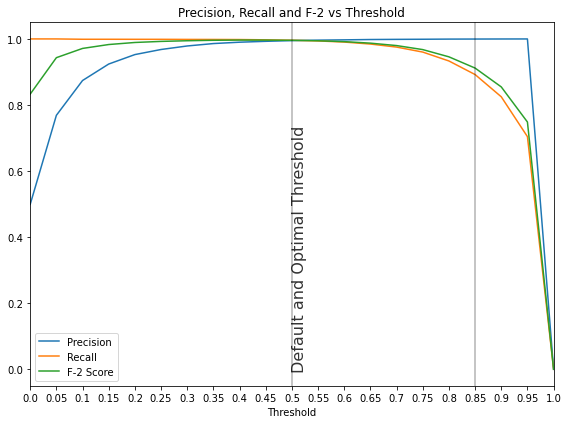

In [230]:
plt.plot(x, df_threshold['Precision'])
plt.plot(x, df_threshold['Recall'])
plt.plot(x, df_threshold['F-2 Score'])
plt.xticks(df_threshold['Threshold'], df_threshold['Threshold'].values)
plt.axvline(0.85, color='black', alpha=0.3)
plt.text(.5,.5,'',rotation=90, alpha=0.8, fontsize=16)
plt.axvline(0.5, color='black', alpha=0.3)
plt.text(.5,.0,'Default and Optimal Threshold',rotation=90, alpha=0.8, fontsize=16)
plt.xlabel('Threshold')
plt.legend(df_threshold[['Precision', 'Recall', 'F-2 Score']].columns)
plt.title('Precision, Recall and F-2 vs Threshold')
plt.xlim(0, 1)

plt.tight_layout()
plt.savefig('Thresholding: Precision, Recall and F-2 vs Threshold.png')

# New Context - Songs

The model predicts the source of the text very well, however it would be interesting to see how well the model predicts outside of the context of a social media posting.  Therefore, I decided to apply the model to lyrics of songs.  A quick search online identified some songs about suicide and some that were not about suicide.  The top performing model was applied to see how well the model performed with this new material from a different medium.


In [243]:

save_myself ='i gave all my oxygen to people that could breathe i gave away my money and now we do not even speak i drove miles and miles but would you do the same for me oh honestly offered off my shoulder just for you to cry upon gave you constant shelter and a bed to keep you warm they gave me the heartache and in return i gave a song it goes on and on life can get you down so i just numb the way it feelsi drown it with a drink and out of date prescription pills and all the ones that love me they just left me on the shelf my farewell so before i save someone else i have got to save myself i gave you all my energy and i took away your pain because human beings are destined to radiate or dream what line do we stand upon because from here looks the same and only scars remain life can get you down so i just numb the way it feels i drown it with a drink and out of date prescription pills and all the ones that love me they just left me on the shelf my farewell so before i save someone else i have got to save myself but if do not then i will go back to where i am rescuing a stranger just because they needed saving just like that oh i am here again between the devil and the danger but i guess it is just my nature my dad was wrong because i am not like my mum because she would just smile and i am complaining in a song but it helps so before i save someone else i have got to save myself life can get you down so i just numb the way it feels i drown it with a drink and out of date prescription pills and all the ones that love me they just left me on the shelf my farewell so before i save someone else  i have got to save myself '

In [244]:
everybody_hurts ='when your day is long and the night the night is yours alone when you are sure you have had enough of this life well hang on do not let yourself go because everybody cries everybody hurts sometimes ometimes everything is wrong now its time to sing along when your day is night alone hold on hold on if you feel like letting go hold on if you think you have had too much of this life well hang on because everybody hurts take comfort in your friends everybody hurts do not throw your hand oh no do not throw your hand if you feel like you are alone no no no you are not alone if you are on your own in this life the days and nights are long when you think you have had too much of this life to hang on well everybody hurts sometimes everybody cries everybody hurts sometimes and everybody hurts sometimes so hold on hold on hold on hold on hold on hold on hold on hold on everybody hurts'

In [245]:
fire_rain ='just yesterday morning they let me know you were gone suzanne the plans they made put an end to you i walked out this morning and i wrote down this song i just can not remember who to send it to i have seen fire and I have seen rain i have seen sunny days that i thought would never endi have seen lonely times when i could not find a friend but i always thought that i would see you again will you not look down upon me jesus you have got to help me make a stand you have just got to see me through another day my body is aching and my time is at hand and i will not make it any other way oh  i have seen fire and i have seen rain i have seen sunny days that i thought would never end i have seen lonely times when i could not find a friend but i always thought that i would see you again been walking my mind to an easy time my back turned towards the sun lord knows, when the cold wind blows it will turn your head around well there is hours of time on the telephone line to talk about things to come sweet dreams and flying machines in pieces on the ground oh i have seen fire and I have seen rain i  have seen sunny days that i thought would never end i have seen lonely times when i could not find a friend but i always thought that I would see you baby one more time again now thought i would see you one more time again there is just a few things coming my way this time around now thought i would see you thought I would see you fire and rain now'

In [246]:
happy_know_it = 'if you are happy and you know it clap your hands if you are happy and you know it then your face will surely show it if you are happy and you know if clap your hands'

In [247]:
wonderful_world = 'i see trees of green red roses too i see them bloom for me and you and i think to myself what a wonderful world i see skies of blue and clouds of white the bright blessed day the dark sacred night and i think to myself what a wonderful world the colors of the rainbow so pretty in the sky are also on the faces of people going by i see friends shaking hands saying how do you do they are really saying i love you i hear babies crying i watch them grow they willl learn much more than i will ever know and i think to myself what a wonderful world yes i think to myself what a wonderful world ooh yes'

In [248]:
r_roll = 'we are no strangers to love you know the rules and so do i a full commitment is what i am thinking of you would not get this from any other guy i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it and if you ask me how i am feeling do not tell me you are too blind to see never gonna give you up never gonna let you down  never gonna run around and desert you never gonna make you cry never gonna say goodbye  never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you '

In [249]:
suicidal_thoughts = 'hello aw shit nigga what the fuck time is it man oh goddamn nigga do you know what time it is aw shit what the fuck is going on you aight nigga what the fuck is wrong with you when i die fuck it i wanna go to hell because i am a piece of shit it is not hard to fucking tell it does not make sense going to heaven with the goodie-goodies dressed in white i like black timbs and black hoodies god i will probably have me on some real strict shit no sleeping all day no getting my dick licked hanging with the goodie-goodies lounging in paradise fuck that shit i want to tote guns and shoot dice you talking some crazy shit now nigga all my life i been considered as the worst lying to my mother even stealing out her purse crime after crime from drugs to extortion i know my mother wish she got a fucking abortion she does not even love me like she did when i was younger get a hold of yourself nigga sucking on her chest just to stop my fucking hunger i wonder if i died would tears come to her eyes forgive me for my disrespect forgive me for my lies my baby mother iss eight months her little sister is two who is to blame for both of them nah nigga not you i swear to god i want to just slit my wrists and end this bullshit throw the magnum to my head threaten to pull shit nigga what the fuck and squeeze until the bed is completely red it is too late for this shit man i am glad i am dead a worthless fucking buddha head the stress is building up i cannot i cannot believe yo i am on my way over there man suicide is on my fuckin mind i wanna leave i swear to god i feel like death is fucking calling me but nah  you would not understand nigga talk to me please man you see it is kinda like the crack did to pookie in new jack except when i cross over there is no coming back yo i am going to call you when i get in the car should i die on the train track like ramo in beat street people at the funeral fronting like they miss me ayo where your girl at man my baby mama kiss me but she glad i am gone yo put your girl on the phone nigga she know me and her sister had something going on i reach my peak i cannot speak ayo, you listening to me motherfucker call my nigga chic tell him that my will is weak ayo come on nigga i am sick of niggas lying i am sick of bitches hawking matter of fact i am sick of talking ayo big ayo big please hang up and try your call again please hang up this is a recording '


In [250]:
adams_song = 'i never thought i would die alone i laughed the loudest who wouldd have known i trace the cord back to the wall no wonder it was never plugged in at all i took my time i hurried up the choice was mine i did not think enough i am too depressed to go on you will be sorry when i am gone i never conquered rarely came sixteen just held such better days days when i still felt alive we could not wait to get outside the world was wide too late to try the tour was over we had survived i could not wait until i got home to pass the time in my room alone i never thought i would die alone another six months i will be unknown give all my things to all my friends you will never step foot in my room again you will close it off board it up remember the time that i spilled the cup of apple juice in the hall please tell mom this is not her fault i never conquered rarely came sixteen just held such better days days when i still felt alive we could not wait to get outside the world was wide too late to try the tour was over we had survived i could not wait till i got home to pass the time in my room alone i never conquered rarely came tomorrow holds such better days days when i can still feel alive when i ca not wait to get outside the world is wide the time goes by the tour is over i have survived i can not wait until i get home to pass the time in my room alone'

In [251]:
cemetary_drive = 'this night walk the dead in a solitary style and crash the cemetery gates in the dress your husband hates way down mark the grave where the search lights find us drinking by the mausoleum door and they found you on the bathroom floor i miss you i miss you so far and the collision of your kiss that made it so hard back home off the run singing songs that make you slit your wrists it is not that much fun staring down a loaded gun so, i will not stop dying will not stop lying if you want i will keep on crying did you get what you deserve is this what you always want me for i miss you i miss you so far and the collision of your kiss that made it so hard way down way down way down, way down i miss you i miss you so far and the collision of your kiss that made it so hard when will i miss you when will i miss you so far and the collision of your kiss that made it so hard made it so hard way down way down '

In [252]:
haunted = 'louder louder the voices in my head whispers taunting all the things you said faster the days go by and i am still stuck in this moment of wanting you here time in the blink of an eye you held my hand you held me tight now you are gone and i am still crying shocked broken i am dying inside where are you i need you do not leave me here on my own speak to me be near me i can not survive unless i know you are with me shadows linger only to my eye i see you i feel you do not leave my side it is not fair just when i found my world they took you they broke you they tore out your heart i miss you you hurt me you left with a smile mistaken your sadness was hiding inside now all that is left are the pieces to find the mystery you kept the soul behind a guise where are you i need you do not leave me here on my own speak to me be near me i can not survive unless i know you are with me why did you go all these questions run through my mind i wish i could not feel at all let me be numb i am starting to fall where are you i need you do not leave me here on my own speak to me be near me i can not survive unless i know you are with me where are you where are you you were smiling'

In [253]:
dict1 = {'title':['Fire and Rain', 'Everybody Hurts', 'Happy and You Know It', 'Wonderful World', 'Never Gonna Give You Up', 'Save Myself', 'Adams Song', 'Cemetary Drive', 'Haunted'],
        'song':[fire_rain, everybody_hurts, happy_know_it, wonderful_world, r_roll, save_myself, adams_song, cemetary_drive, haunted],
        'length':[len(fire_rain), len(everybody_hurts), len(happy_know_it), len(wonderful_world), len(r_roll), len(save_myself), len(adams_song), len(cemetary_drive), len(haunted)], 
         'class': [1, 1 ,0, 0, 0, 1, 1, 1, 1]
       }

In [256]:
df_song = pd.DataFrame(dict1)

In [257]:
df_song

,title,song,length,class
0,Fire and Rain,just yesterday morning they let me know you we...,1455,1
1,Everybody Hurts,when your day is long and the night the night ...,886,1
2,Happy and You Know It,if you are happy and you know it clap your han...,165,0
3,Wonderful World,i see trees of green red roses too i see them ...,598,0
4,Never Gonna Give You Up,we are no strangers to love you know the rules...,1741,0
5,Save Myself,i gave all my oxygen to people that could brea...,1632,1
6,Adams Song,i never thought i would die alone i laughed th...,1364,1
7,Cemetary Drive,this night walk the dead in a solitary style a...,911,1
8,Haunted,louder louder the voices in my head whispers t...,1181,1


In [258]:
lr_tfid = LogisticRegression(C = 10)
lr_tfid.fit(X_test11, y_test11)

LogisticRegression(C=10)

In [259]:
text_matrix =  vectorizor_tfid.transform(df_song['song'])
X_song = text_matrix.tocsc()
y_song = df_song['class']

In [260]:
lr_tfid.predict(X_song)

array([0, 1, 0, 0, 0, 1, 1, 1, 1])

In [261]:
song_pred = lr_tfid.predict(X_song)

In [262]:
metrics.recall_score(y_song,song_pred, pos_label = 1)

0.8333333333333334